# <font color="orange">CONTEXT</font>

<font color="grey-black">Le but de cet exercice est d'étudier des données de matches de tennis. Le but est de prédire le gagnant d'un match de tennis avec les données disponibles. Il est demandé de faire cet exercice dans une limite de temps de 8 heures.</font>

<font color="grey-black">Ce notebook commence par une section <b>SETUP</b> où j'importe les packages Python utilisés dans la suite de ce notebook (data viz, machine learning, manipulation de la données, ...). La partie suivante est la partie où je charge les données avec `pandas` puis construis un dictionnaire de données pour rappeler le contexte et les données disponibles pour l'exercice (voir les données sur Kaggle)[https://www.kaggle.com/sijovm/atpdata].</font>

<font color="grey-black">Ensuite, je nettoie rapidement les données aberrantes, trie le jeu de données par date. C'est le premier nettoyage de données.</font>

<font color="grey-black">Après ce premier nettoyage rapide, je commence l'exploration des données. J'ai décidé de mener cette exploration sans imputer les valeurs manquantes dans le jeu de données pour ne pas polluer le jeu de donnéees et avoir des conclusions fausses au regard de la modification des distributions changées par l'imputation des données manquantes.</font>

<font color="grey-black">Enfin, je me lance dans la modélisation et la prédiction du vainqueur d'un match. J'ai développé un premier modèle "baseline" pour faire un banchmark des autres modèles plus sophistiqués. Au final, dans la limite de temps imposé, je n'ai eu le temps de développé qu'un seul autre modèle, sans faire de feature engineering ou presque.</font>

<font color="grey-black">Parce que l'exercice est limité dans le temps, en guise de conclusion, je reviens sur les performances des modèles et laisse une liste de choses qui peuvent être faites pour améliorer la connaissance des données disponibles et la performance du meilleur modèle de prédiction.</font>

# <font color="orange">SETUP</font>

In [1]:
# pour la manipulation de donnees
import pandas as pd
from dfply import * # package permettant d'utiliser la syntaxe de package R dplyr

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

import numpy as np # pour le calcul matriciel

# fonctions utiles pour le developpement de modeles ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
from hyperopt import tpe

from scipy.stats import shapiro, ttest_rel # test de normalite et t-test paire

# data viz
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


# <font color="orange">LOAD DATA</font>

In [2]:
df = pd.read_csv("../data/ATP.csv")

In [3]:
df.shape

(169690, 49)

<font color="grey-black">Le jeu de données a 169690 lignes et 49 colonnes.</font>

In [4]:
df.head()

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_entry,loser_hand,loser_ht,loser_id,loser_ioc,loser_name,loser_rank,loser_rank_points,loser_seed,match_num,minutes,round,score,surface,tourney_date,tourney_id,tourney_level,tourney_name,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed
0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,107760,AUS,Max Senior,NaN,NaN,NaN,1,NaN,R64,12-10 7-5 4-6 7-5,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,110023,AUS,Richard Coulthard,NaN,NaN,NaN
1,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,106964,AUS,Ernie Mccabe,NaN,NaN,NaN,2,NaN,R64,6-3 6-2 6-4,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.520876,NaN,R,NaN,109803,AUS,John Brown,NaN,NaN,NaN
2,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,110024,INA,Gondo Widjojo,NaN,NaN,15.0,3,NaN,R64,6-4 3-6 6-3 7-5,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.216290,NaN,R,NaN,100257,AUS,Ross Case,NaN,NaN,NaN
3,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,110025,AUS,Robert Layton,NaN,NaN,NaN,4,NaN,R64,6-4 6-2 6-1,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.264203,NaN,R,NaN,100105,AUS,Allan Stone,NaN,NaN,5.0
4,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,NaN,110026,AUS,Bert Kearney,NaN,NaN,NaN,5,NaN,R64,6-4 6-1 7-5,Grass,19680119,1968-580,G,Australian Chps.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.861739,NaN,R,NaN,109966,AUS,Warren Jacques,NaN,NaN,NaN


## <font color="green">DATA DICTIONARY</font>

<font color="grey-black">Le dictionnaire de données est fourni sur [la page Kaggle du jeu de données](https://www.kaggle.com/sijovm/atpdata).</font>

* `tourney_id` - tournament's id
* `tourney_name` - tournament's name
* `surface` - surface in which the match is played
* `draw_size` - the size of the draw
* `tourney_level` - tournament level ('G' = Grand Slams, 'M' = Masters 1000s, 'A' = other tour-level events, 'C' = Challengers, 'S' = Satellites/ITFs, 'F' = Tour finals and other season-ending events, 'D' = Davis Cup)
* `tourney_date` - starting date of the tournament
* `match_num` - match number in a certain tournament
* `winner_id` & `loser_id` - player id
* `winner_seed` & `loser_seed` - the seed of the player in that tournament
* `winner_entry` & `loser_entry` - How did the player enter the tournaments? (WC - Wildcard, Q - Qualifier, LL - Lucky loser, PR - Protected ranking, SE - Special Exempt, ALT - Alternate player)
* `winner_name` & `loser_name` - player name
* `winner_hand` & `loser_hand` - hand of the player, right or left
* `winner_ht` & `loser_ht` - the height of the player
* `winner_ioc` & `loser_ioc` - the country of origin
* `winner_age` & `loser_age` - age of the player
* `score` - final score in the match
* `best_of` - the maximum number of sets played
* `round` - the round in the tournament a match belongs to
* `minutes` - duration of the match in minutes
* `w_ace`& `l_ace` - number of aces in the match
* `w_df`& `l_df` - double faults
* `w_svpt`& `l_svpt` - serve percent
* `w_1stIn` & `l_1stIn` - first serve in percent
* `w_1stWon` & `l_1stWon` - first serve winning percent
* `w_2ndWon` & `l_2ndWon` - second serve winning percent
* `w_SvGms` & `l_SvGms` - number of games played on serve (So, the maximum difference between wSvGms and lSvGms will be 1)
* `w_bpSaved` & `l_bpSaved` - breakpoints saved
* `w_bpFaced` & `l_bpFaced` - breakpoints faced

Columns not in the data dictionary:
* `loser_rank`
* `loser_rank_points`
* `winner_rank`
* `winner_rank_points`

In [5]:
df.dtypes

best_of                 int64
draw_size             float64
l_1stIn               float64
l_1stWon              float64
l_2ndWon              float64
l_SvGms               float64
l_ace                 float64
l_bpFaced             float64
l_bpSaved             float64
l_df                  float64
l_svpt                float64
loser_age             float64
loser_entry            object
loser_hand             object
loser_ht              float64
loser_id                int64
loser_ioc              object
loser_name             object
loser_rank            float64
loser_rank_points     float64
loser_seed            float64
match_num               int64
minutes               float64
round                  object
score                  object
surface                object
tourney_date            int64
tourney_id             object
tourney_level          object
tourney_name           object
w_1stIn               float64
w_1stWon              float64
w_2ndWon              float64
w_SvGms   

In [6]:
df.describe()

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_ht,loser_id,loser_rank,loser_rank_points,loser_seed,match_num,minutes,tourney_date,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_ht,winner_id,winner_rank,winner_rank_points,winner_seed
count,169690.000000,1232.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,164700.000000,139052.000000,169690.000000,145909.000000,93025.000000,32853.000000,169690.000000,82103.000000,1.696900e+05,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,83415.000000,167929.000000,150884.000000,169690.000000,149773.000000,94291.000000,65295.000000
mean,3.446072,75.022727,47.705149,31.683690,15.029119,12.159995,4.779776,8.751555,4.808044,3.509081,80.717904,25.661378,184.064918,102829.308574,120.815721,840.134727,7.589109,52.853492,100.786037,1.993052e+07,47.299514,35.659522,16.806102,12.354780,6.461823,5.174381,3.528790,2.743859,77.906887,25.612639,184.277200,102362.973540,81.409827,1342.313296,6.209495
std,0.832567,43.500071,19.359849,14.437267,7.266522,4.114587,4.625035,4.123616,3.271050,2.623945,29.485231,4.074386,6.624417,6072.998247,161.539365,940.800241,5.880047,81.992868,40.332392,1.396612e+05,19.191976,13.841457,7.026601,4.102224,5.297845,4.058311,3.081844,2.368677,29.532338,3.943494,6.632803,3958.369064,123.875156,1672.646568,5.401583
min,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,0.000000,14.380000,160.000000,100001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.968012e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.360000,160.000000,100002.000000,1.000000,1.000000,1.000000
25%,3.000000,64.000000,34.000000,21.000000,10.000000,9.000000,2.000000,6.000000,2.000000,2.000000,59.000000,22.750000,180.000000,100529.000000,40.000000,367.000000,4.000000,9.000000,73.000000,1.981052e+07,33.000000,26.000000,12.000000,9.000000,3.000000,2.000000,1.000000,1.000000,56.000000,22.760000,180.000000,100445.000000,18.000000,496.000000,2.000000
50%,3.000000,64.000000,44.000000,29.000000,14.000000,11.000000,4.000000,8.000000,4.000000,3.000000,75.000000,25.320000,185.000000,101736.000000,77.000000,618.000000,6.000000,22.000000,94.000000,1.993021e+07,44.000000,33.000000,16.000000,11.000000,5.000000,4.000000,3.000000,2.000000,73.000000,25.250000,185.000000,101611.000000,48.000000,835.000000,5.000000
75%,3.000000,128.000000,58.000000,39.000000,19.000000,15.000000,7.000000,11.000000,7.000000,5.000000,96.000000,28.250000,188.000000,103821.000000,134.000000,985.000000,10.000000,45.000000,123.000000,2.005022e+07,57.000000,43.000000,21.000000,15.000000,9.000000,7.000000,5.000000,4.000000,94.000000,28.130000,188.000000,103694.000000,96.000000,1508.000000,8.000000
max,5.000000,128.000000,328.000000,284.000000,101.000000,91.000000,103.000000,35.000000,28.000000,26.000000,489.000000,63.690000,208.000000,208997.000000,2159.000000,16950.000000,35.000000,701.000000,1146.000000,2.019022e+07,361.000000,292.000000,82.000000,90.000000,113.000000,34.000000,24.000000,23.000000,491.000000,58.718686,208.000000,208996.000000,2101.000000,16950.000000,35.000000


# <font color="orange">PREMIER NETTOYAGE DE DONNÉES</font>

In [7]:
any(df.duplicated())

False

<font color="grey-black">Le jeu de données n'a aucun doublon.</font>

<font color="grey-black">Renommer la colonne `round` car c'est un mot réservé ("key word") en Python, donc pour éviter toute erreur, mieux vaut changer le nom de la colonne.</font>

In [8]:
df = df.rename({'round': 'tourney_stage'}, axis='columns')

<font color="grey-black">Reordonner le jeu de données par date et extraire l'année du tournoi pour faire des statistiques par an.</font>

In [9]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format="%Y%m%d")
df = df.sort_values(['tourney_date', 'tourney_id', 'match_num'])

In [10]:
df['tourney_year'] = df['tourney_date'].dt.year

<font color="grey-black">Remplacer la chaine de charactères 'None' dans la colonne `surface` par une valeur manquante `NaN`</font>

In [11]:
df['surface'] = df['surface'].replace({'None': np.nan})

<font color="grey-black">La colonne `l_bpSaved` a deux observations négatives, ce qui n'est pas possible : le nombre de balles de break sauvées ne peut qu'être positif ou nul au minimum.</font>

In [12]:
df.loc[df['l_bpSaved'] < 0, 'l_bpSaved'] = 0

<font color="grey-black">La colonne `l_svpt` a 17773 observations supérieures à 100, or ce n'est normalement pas possible, puisque cette vraible doit représenter le pourcentage de 1er services du joueur perdant. Mais en regardant les statistiques du match [Kyrgos - Isner à Acapulco en 2019](https://www.atptour.com/en/scores/2019/807/MS002/match-stats), remporté par Isner, on se rend compte que la variable `l_svpt` est égale au nombre de 1er services tentés par Isner. Donc il est normal d'avoir des valeurs supérieures à 100.  
On observe la même chose pour la variable `w_svpt`.</font>

<font color="grey-black">Je n'ai pas vu d'autres soucis majeurs dans la qualité des données. Et préssé par le temps, je laisse cette partie là en suspens quitte à revenir plus tard, durant le déroulé de l'exploration des données ou la construction des modèles.</font>

In [13]:
any(df.duplicated())

False

<font color="grey-black">Même après toutes ces transformations, le jeu de données n'a aucun doublon.</font>

### <font color="brown">CREATE DICTIONARY OF PLAYERS WITH STATIC DATA</font>

<font color="grey-black">Pour commencer, je crée un jeu de données pour rassembler l'ensemble des données "statiques" disponibles pour chaque joueur présent (âge, taille, pays d'origine, main préférentielle, etc...) Cela permet de rapidement fusioner ces données statiques si nécessaire, notamment dans l'exploration de données.</font>

In [14]:
# first extract ids in loser and winner columns with static columns (and drop duplicates)
losers = df[['loser_id', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc']].drop_duplicates()
winners = df[['winner_id', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc']].drop_duplicates()

In [15]:
# rename columns
for col in losers.columns:
    losers.rename(columns={col: col.split('_')[-1]}, inplace=True)
for col in winners.columns:
    winners.rename(columns={col: col.split('_')[-1]}, inplace=True)

In [16]:
# check for players with same id and different names if any...
print(losers[losers['id'] == losers[losers.duplicated(['id'])]['id'].values[0]])
print(winners[winners['id'] == winners[winners.duplicated(['id'])]['id'].values[0]])

          id                    name hand     ht  ioc
608   100032  Patricio Rodriguez CHI    R  188.0  CHI
1576  100032  Patricio Rodriguez Chi    R  188.0  CHI
          id                    name hand     ht  ioc
541   100032  Patricio Rodriguez CHI    R  188.0  CHI
1656  100032  Patricio Rodriguez Chi    R  188.0  CHI


<font color="grey-black">Patricio Rodriguez a deux noms différents dans le jeu de données, nettoyons ça une bonne fois pour toute.</font>

In [17]:
losers.loc[losers['id'] == 100032, 'name'] = "Patricio Rodriguez"
winners.loc[winners['id'] == 100032, 'name'] = "Patricio Rodriguez"

In [18]:
losers = losers.drop_duplicates()
winners = winners.drop_duplicates()

In [19]:
any(losers.duplicated())

False

<font color="grey-black">Maintenant on peut créer un jeu de données avec les caractéristiques des joueurs à partir de leur IDs.</font>

In [20]:
losers.set_index('id').to_dict(orient='index')[109978]

{'name': 'Tony Pospisil', 'hand': 'U', 'ht': nan, 'ioc': 'CAN'}

In [21]:
players = losers.set_index('id').to_dict(orient='index')
players.update(winners.set_index('id').to_dict(orient='index'))

# create a pandas DataFrame from this dictionary to be able to join it quickly
players_data = pd.DataFrame.from_dict(players, orient='index').reset_index().rename(columns={'index': 'player_id'})

<font color="grey-black">Par exemple, si l'on veut les statistiques du joueur avec ID = 109978, il suffit d'interroger le dictionnaire ou le `pandas` DataFrame</font>

In [22]:
players[109978]

{'name': 'Tony Pospisil', 'hand': 'U', 'ht': nan, 'ioc': 'CAN'}

In [23]:
players_data[players_data['player_id'] == 109978]

,player_id,name,hand,ht,ioc
619,109978,Tony Pospisil,U,NaN,CAN


# <font color="orange">EXPLORATORY DATA ANALYSIS (EDA)</font>

<font color="grey-black">Dans l'EDA, je commence par observer quelques stastiques intéressantes, sur le nombre de matches et de victoires par joueur, puis sur l'évolution du tennis dans le temps. Cela permet de mieux comprendre le jeu de données et de se faire une idée sur ce qu'il peut être fait autour de celui-ci.  
Ensuite, j'étudie quelques statistiques de joueurs dans le jeu de données qui pourraient donner une indication sur la probabilité de tel joueur de gagné contre un autre. Cela permet d'itentifier quelques variables intéressantes pour notre objectif : prédire l'issue d'un match de tennis.  
Après cette partie EDA, je développerai une partie modèle de prédiction.</font>

## <font color="green">STATISTIQUES DES MATCHES ET EVOLUTION DU TENNIS</font>

In [24]:
print("Periode d'observation : du {} au {}".format(min(df['tourney_date']), max(df['tourney_date'])))

Periode d'observation : du 1968-01-19 00:00:00 au 2019-02-25 00:00:00


<font color="grey-black">La période observée concentre donc l'ensemble de [l'ère Open du tennis](https://fr.wikipedia.org/wiki/Ère_Open), c'est-à-dire l'ère moderne du tennis jusqu'au début de l'année 2019.</font>

### <font color="brown">NUMBER OF MATCH PER PLAYER</font>

In [25]:
print("Il y a {} differents joueurs dans le jeu de données, pour {} matches".format(len(players), df.shape[0]))

Il y a 5894 differents joueurs dans le jeu de données, pour 169690 matches


<font color="grey-black">Sur cette période de l'ère Open, 5894 joueurs ont joué au moins un match.</font>

<font color="grey-black">Distribution du nombre de matches par joueur :</font>

In [26]:
nb_lost = df['loser_id'].value_counts().to_frame(name="nb_lost")

nb_win = df['winner_id'].value_counts().to_frame(name="nb_wins")

nb_matches = pd.concat([nb_lost, nb_win], axis=1, sort=False).fillna(0)
nb_matches['total'] = nb_matches['nb_lost'] + nb_matches['nb_wins']
nb_matches = nb_matches.sort_values(['total'], ascending=False)
nb_matches = nb_matches.reset_index().rename({'index': 'player_id'}, axis='columns')

In [27]:
nb_matches = pd.merge(nb_matches, players_data, how='left')

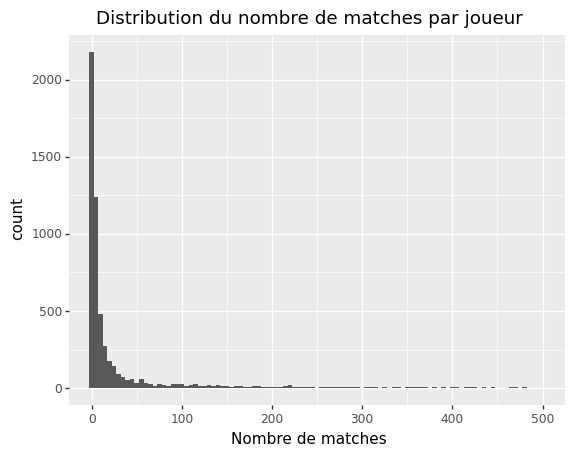

<ggplot: (309597873)>

In [28]:
(
    ggplot(nb_matches, aes(x='total'))
    + geom_histogram(binwidth=5)
    + coord_cartesian(xlim=(0, 500))
    + xlab("Nombre de matches")
    + ggtitle("Distribution du nombre de matches par joueur")
)

In [29]:
print("{:.2f}% des joueurs ont joué moins de 5 matches".format(sum(nb_matches['total'] < 5) / nb_matches.shape[0] * 100))

48.83% des joueurs ont joué moins de 5 matches


In [30]:
print("{:.2f}% des joueurs ont joué un seul match".format(sum(nb_matches['total'] == 1) / nb_matches.shape[0] * 100))

24.58% des joueurs ont joué un seul match


<font color="grey-black">Beacoup de joueur n'ont disputé que très peu de matches dans ce jeu de données : environ 49% des joeurs ont moins de 5 matches, et presque un quart des joueurs n'ont fait qu'un match.</font>

<font color="grey-black">Quel joueur ont fait le plus de matches dans leur carrière ?</font>

In [31]:
most_matches = nb_matches.head(10)
most_matches.loc[:,['name']] = pd.Categorical(most_matches['name'], categories=most_matches['name'], ordered=True)

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


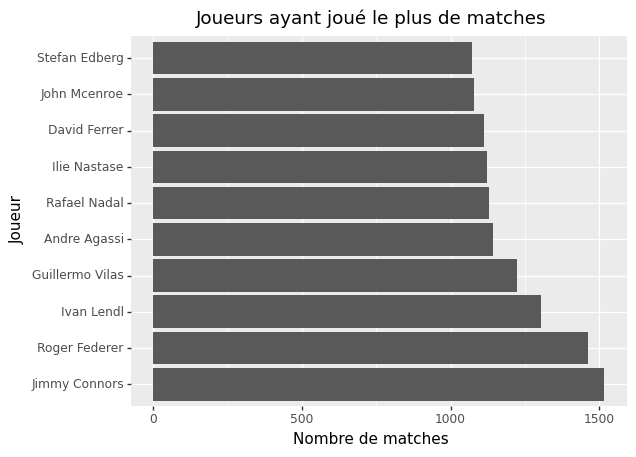

<ggplot: (309457913)>

In [32]:
(
    ggplot(most_matches, aes(x='name', y='total'))
    + geom_bar(stat="identity")
    + xlab("Joueur")
    + ylab("Nombre de matches")
    + ggtitle("Joueurs ayant joué le plus de matches")
    + coord_flip()
)

<font color="grey-black">On ne retourve que des légendes du jeu (à part peut-être David Ferrer, qui est le seul a ne pas avoir remporté de Grand Chelem). Ce sont des joueurs qui ont beaucoup gagné, et donc disputé beaucoup de matches. Seul 2 joueurs sont encore en activité : Roger Federer et Rafael Nadal.</font>

<font color="grey-black">Quels sont les joueurs qui ont remporté le plus de tournoi ?</font>

In [33]:
top_winners = (
    df >>
    mask(X.tourney_stage == 'F') >>
    select(X.winner_id, X.winner_name, X.tourney_level) >>
    group_by(X.winner_id, X.winner_name, X.tourney_level) >>
    mutate(nb = n(X.winner_id)) >>
    ungroup() >>
    group_by(X.winner_id, X.winner_name) >>
    mutate(total = n(X.winner_id)) >>
    distinct(X.winner_id, X.winner_name, X.tourney_level, X.nb, X.total)
)

In [34]:
top_winners = top_winners.sort_values(['total'], ascending=False)
top_winners['winner_name'] = pd.Categorical(top_winners['winner_name'], categories=top_winners['winner_name'].drop_duplicates(), ordered=True)
top_winners = top_winners[top_winners.winner_name.isin(top_winners.winner_name.drop_duplicates().head(10))]

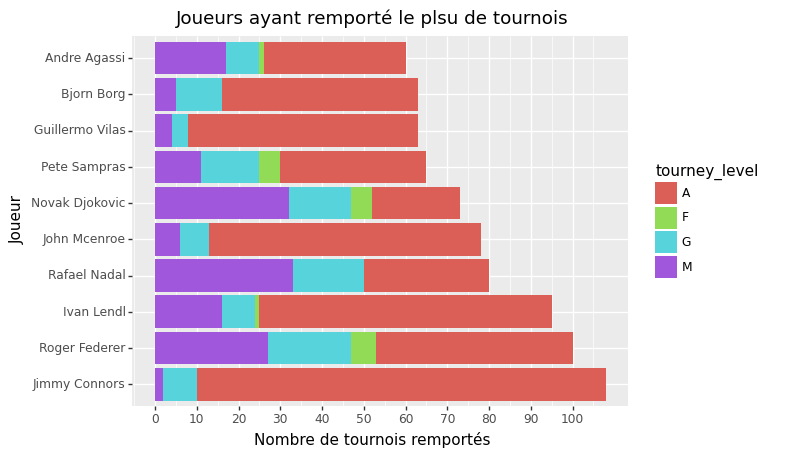

<ggplot: (310394717)>

In [35]:
(
    ggplot(top_winners, aes(x='winner_name', y='nb', fill='tourney_level'))
    + geom_bar(stat="identity")
    + scale_y_continuous(breaks = range(0,max(top_winners['total']), 10))
    + xlab("Joueur")
    + ylab("Nombre de tournois remportés")
    + ggtitle("Joueurs ayant remporté le plsu de tournois")
    + coord_flip()
)

<font color="grey-black">Dans cette première partie, nous avons pu voir certaines informations intéressantes :</font>
- <font color="grey-black">Beaucoup de joueurs ont joué très peu de matches (la moitié, moins de 5 matches, et un quart un seul match).</font>
- <font color="grey-black">Les joueurs qui ont le plus gagné de tournois sont ceux qui ont joué le plus de matches.</font>
- <font color="grey-black">Les légendes du tennis ont joué beaucoup de matches.
Pour pouvoir prédire l'issue d'un match impliquant un joueur, je pense qu'il est nécessaire d'avoir le plus de données possible sur ce joueur en particulier. Ces données étant manquantes, la création de nouvelles variables peut prendre un rôle encore plus importante pour avoir une performance d'un modèle de prédiction.</font>

### <font color="brown">EVOLUTIONS DU TENNIS</font>

<font color="grey-black">On peut se demander quel sont les grandes évolutions qu'a connu le tennis depuis le début de l'ère Open ?</font>

<font color="grey-black">Commençons par regarder l'évolution des différentes surfaces de jeu.</font>

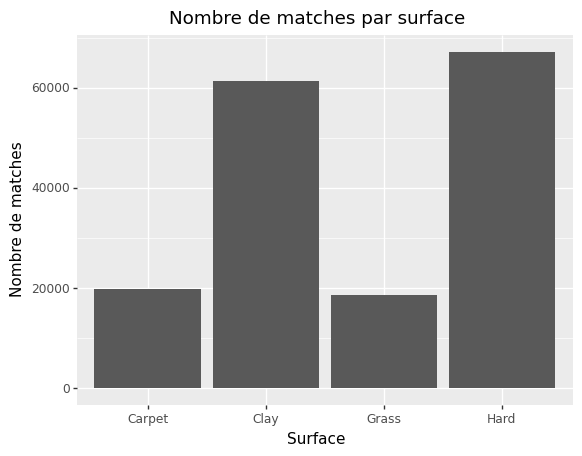

<ggplot: (309355221)>

In [36]:
(
    df >>
    select(X.surface) >>
    group_by(X.surface) >>
    mutate(n=n(X.surface)) >>
    distinct(X.surface, X.n) >>
    ggplot(aes(x='surface', y='n'))
    + geom_bar(stat="identity")
    + xlab("Surface")
    + ylab("Nombre de matches")
    + ggtitle("Nombre de matches par surface")
)

<font color="grey-black">La plupart des matches de l'ère Open se sont joués sur terre battue ou dur (ciment).</font>

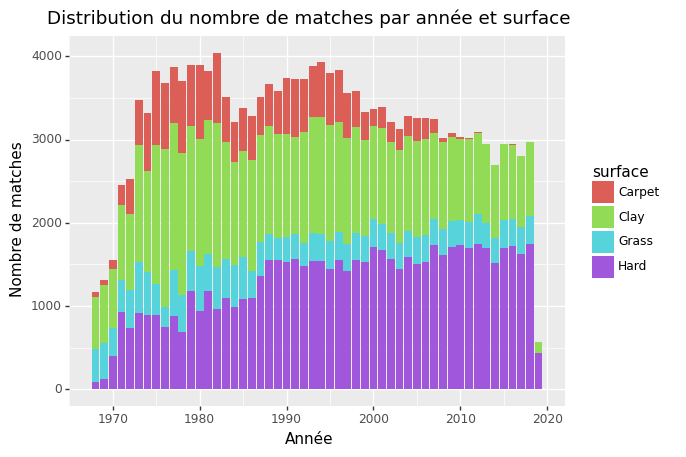

<ggplot: (309357333)>

In [37]:
(
    df >>
    select(X.tourney_year, X.surface) >>
    group_by(X.tourney_year, X.surface) >>
    mutate(n=n(X.tourney_year)) >>
    distinct(X.tourney_year, X.surface, X.n) >>
    ggplot(aes(x='tourney_year', y='n', fill='surface'))
    + geom_bar(stat="identity")
    + xlab("Année")
    + ylab("Nombre de matches")
    + ggtitle("Distribution du nombre de matches par année et surface")
)

<font color="grey-black">Depuis le milieu des années 1990, la moquette a commencé à disparaitre, et en moins de 10 ans, plus aucun tournoi ne se joue sur cette surface. Et de moins en moins de matchs ne disputent sur herbe, peu à peu remplacer par une surface dure. Deux facteurs peuvent expliquer la contraction de cette surface historique du tennis :</font>
- <font color="grey-black">le spectacle est moins télévisuel sur herbe (moins d'échanges, plus de points en un ou deux coups de raquette, etc...) et donc pour attirer les diffuseurs cette surface est abandonée par une parti du circuit mondial de tennis</font>
- <font color="grey-black">les cours de tennis en herbe demandent plus d'entretien que des courts en dur et il eput être compliqué d'entretenir un court en herbe dans certains endroits (comme les pays du Golf, l'Amérique du Sud, etc...) et donc avec la mondialisation du tennis qui s'est accélérée depuis le début de l'ère Open, l'herbe laisse place à des courts en dur ou en terre battue</font>

<font color="grey-black">Le nombre de matches par saison a-t-il évolué depuis lea fin des années soixante ?</font>

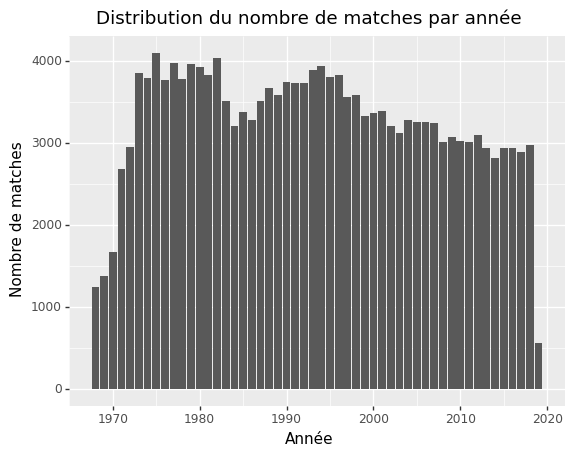

<ggplot: (310652789)>

In [38]:
(
    df >>
    group_by(X.tourney_year) >>
    mutate(n = n(X.match_num)) >>
    ungroup() >>
    distinct(X.n, X.tourney_year) >>
    ggplot(aes(x='tourney_year', y='n'))
    + geom_bar(stat="identity")
    + xlab("Année")
    + ylab("Nombre de matches")
    + ggtitle("Distribution du nombre de matches par année")
)

<font color="grey-black">Depuis le milieu des années 1990, le nombre de match a également baissé. Mais il avait connu une forte augmentation dans les années 1970, pour atteindre presque 4000 matches sur le circuit. Ces dernières années ont plutôt connu environ 3000 matches.</font>

## <font color="green">STATISTIQUES DES JOUEURS ET CORRELATION AVEC LA VICTOIRE</font>

<font color="grey-black">Maintenant, il peut être intéressant de se demander si certaines caractéristiques de joueur (taille, age, main préférée, ...) ont une correlation avec le fait de gagner un match.</font>

### <font color="BROWN">TAILLE DES JOUEURS</font>

<font color="grey-black">Commençons par nous intéressé à la taille d'un joueur.  
Un joueur plus grand a-t-il plus de chance de gagner contre un adversaire plus petit, ou inversement ?
</font>

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 38267 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


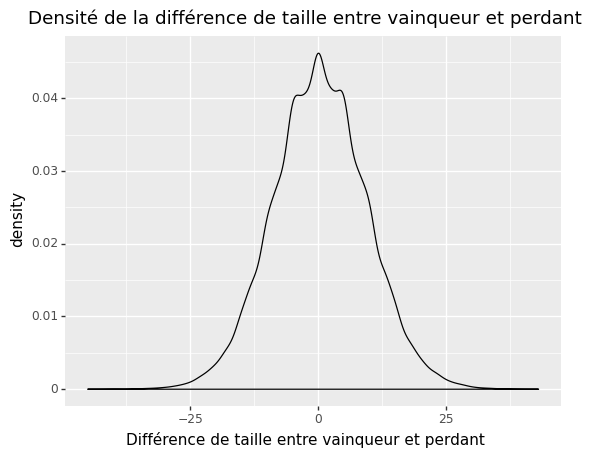

<ggplot: (310406021)>

In [39]:
(
    df >>
    mutate(diff_ht = X.winner_ht - X.loser_ht) >>
    ggplot(aes('diff_ht'))
    + geom_density(adjust=1.5)
    + xlab("Différence de taille entre vainqueur et perdant")
    + ggtitle("Densité de la différence de taille entre vainqueur et perdant")
)

<font color="grey-black">La différence de taille entre les joueurs s'affrontant ne semble pas être un facteur pour déterminer l'issue du match.  
    Vérifions cela par un test statistique.</font>

In [40]:
ttest_rel(df.winner_ht.fillna(df.winner_ht.append(df.loser_ht).median()),
          df.loser_ht.fillna(df.winner_ht.append(df.loser_ht).median()),
          nan_policy='omit')

Ttest_relResult(statistic=6.011461459955253, pvalue=1.8423165182418132e-09)

<font color="grey-black">Le t-test pairé ne permet pas de conclure sur la non différence des moyennes des tailles des gagnants et des perdants. Il faudrait donc creuser un plus pour comprendre cette différence statistique des deux échantillons. Le test supporte l'idée qu'il existe une différence entre les deux moyennes.</font>

### <font color="brown">AGE DES JOUEURS</font>

<font color="grey-black">Regardons maintenant la variable `age`. Existe-t-il une différence statistique significative entre l'âge des gagnants et celui des perdants qu'on on compare les face à face.</font>

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 6231 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


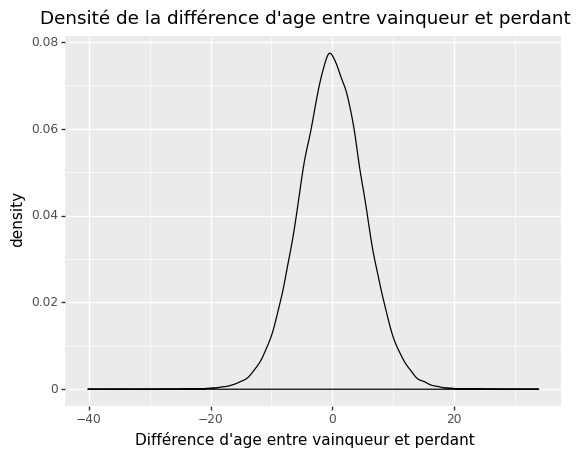

<ggplot: (310548741)>

In [41]:
(
    df >>
    mutate(diff_age = X.winner_age - X.loser_age) >>
    ggplot(aes('diff_age'))
    + geom_density()
    + xlab("Différence d'age entre vainqueur et perdant")
    + ggtitle("Densité de la différence d'age entre vainqueur et perdant")
)

<font color="grey-black">La différence d'age entre les joueurs s'affrontant ne semble pas non plus être un facteur pour déterminer l'issue du match.</font>

In [42]:
ttest_rel(df.winner_age.fillna(df.winner_age.append(df.loser_age).median()), df.loser_age.fillna(df.winner_age.append(df.loser_age).median()), nan_policy='omit')

Ttest_relResult(statistic=-3.1475528151726224, pvalue=0.0016467184540850624)

<font color="grey-black">La différence entre les moyennes de l'âge des gagnants et des perdants est stastiquement différente. Il faudrait donc creuser un plus pour comprendre cette différence statistique des deux échantillons.</font>

### <font color="brown">DROITIER VS GAUCHER</font>

<font color="grey-black">On peut étudier une dernière variable qui est celle de la main préférentielle des joueurs (droitier ou gaucher).</font>

In [43]:
players_data.hand.value_counts(normalize=True)

R    0.691834
U    0.243451
L    0.064715
Name: hand, dtype: float64

<font color="grey-black">Seul 6% des joueurs sont gauchers et 69% sont droitiers (le reste étant non défini).</font>

In [44]:
right_winners = df[(df.winner_hand == 'R') & (df.loser_hand == 'L')]

In [45]:
left_winners = df[(df.winner_hand == 'L') & (df.loser_hand == 'R')]

In [46]:
print("Il y a eu {} face à face entre droitiers et gauchers, et les gauchers en ont remporté {:.2f}%, et représente {:.2f}% du total des victoires".format(
    right_winners.shape[0]+left_winners.shape[0],
    left_winners.shape[0] / (right_winners.shape[0]+left_winners.shape[0]) * 100,
    left_winners.shape[0] / df.shape[0] * 100
)
     )

Il y a eu 40562 face à face entre droitiers et gauchers, et les gauchers en ont remporté 52.30%, et représente 12.50% du total des victoires


<font color="grey-black">Les gauchers ont remporté 12% des matches dans le jeu de données en ne représentant que 6% des joueurs ! Etre gaucher donne plus de chance de remporter un match.</font>

<font color="grey-black">Dans cette première partie du notebook, j'ai donc fait un premier nettoyage de données rapide et regarder quelques données aberrantes. Après ces corrections, je n'ai pas souhaité imputer les valeurs manquantes pour ne pas tirer de conclusions erronées avec ces nouvelles données ajoutées. Pour cela il faudrait imputer les données manquantes et comparer les distributions avec et sans ces données ajoutées pour mesurer les erreurs et biais que cela ajoute.</font>

<font color="grey-black">Parmi les joueurs qui ont le plus joué on retrouve les joueurs qui ont le plus gagné : les légendes du tennis. Depuis le début de l'ère Open, les surface de jeu ont particulièrement changé pour favoriser le spectacle, notammenent télévisuel, et avec la mondialisation du jeu. Mais paradoxalement, malgré la multiplication des pays acceuillant des tournois ATP de tennis, le nombre de matches disputés par saison a diminué le milieu des années 1990.</font>

<font color="grey-black">Les t-test pairés sur l'âge et la taille des vainqueurs et des perdants mets en évidence une différence statistique entre les distributions mais visuellement cette différence n'est pas visible. Il faudrait creuser plus longtemps pour conclure sur cette différence. Et faire ce genre de test sur l'ensemble des variables quantitatives et d'autres tests comme un test ANOVA pour les variables qualitatives. Par contre il parait clair que les gauchers ont tendance à mieux performer que les droitiers sur le circuit mais le petit nombre de gauchers empêche de tirer de réelles conclusions sur cette partie du jeu.</font>

# <font color="orange">MODELES DE PREDICTION</font>

## <font color="green">QUALITÉ DE DONNÉES</font>

<font color="grey-black">Pour pouvoir construire un bon modèle de prédiction, il faut commencer par regarder la qualité du jeu de données. Dans le temps limité de l'exercice, je n'étudie uniquement les valeurs manquantes et l'éventualité de valeurs aberrantes (un age trop jeune ou trop vieux, une taille négative, etc...).</font>

### <font color="brown">DONNÉES ABERRANTES</font>

<font color="grey-black">Je vais rapidement chercher dans le jeu de données pour des données abérrantes (age négatif, taille irréel, etc...).</font>

In [47]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
best_of,169690.0,3.446072,0.832567,3.00,3.00,3.00,3.00,5.000000
draw_size,1232.0,75.022727,43.500071,4.00,64.00,64.00,128.00,128.000000
l_1stIn,83415.0,47.705149,19.359849,0.00,34.00,44.00,58.00,328.000000
l_1stWon,83415.0,31.683690,14.437267,0.00,21.00,29.00,39.00,284.000000
l_2ndWon,83415.0,15.029119,7.266522,0.00,10.00,14.00,19.00,101.000000
l_SvGms,83415.0,12.159995,4.114587,0.00,9.00,11.00,15.00,91.000000
l_ace,83415.0,4.779776,4.625035,0.00,2.00,4.00,7.00,103.000000
l_bpFaced,83415.0,8.751555,4.123616,0.00,6.00,8.00,11.00,35.000000
l_bpSaved,83415.0,4.808164,3.270778,0.00,2.00,4.00,7.00,28.000000
l_df,83415.0,3.509081,2.623945,0.00,2.00,3.00,5.00,26.000000


<font color="grey-black">Il ne semble y avoir de données aberrantes (taille entre 1m60 et 2m08, age entre 14 et 46 ans, ...). Je ne pousserai pas plus loin dans la recherche de données aberrantes.</font>

### <font color="brown">VALEURS MANQUANTES</font>

<font color="grey-black">Je représente l'évolution du nombre de données manquantes par an. Je m'attends à voir plus de valeurs manquantes pour les matches les plus vieux, car on collecte de plus en plus de données dans le monde, et le tennis ne fait pas exception. Surtout sur les plus petits tournois (ATP 250, Challengers, ...).</font>

In [48]:
# creer une nouvelle colonne, du nombre de donnees manquantes par ligne
df['nb_nan'] = df.isnull().sum(axis=1)

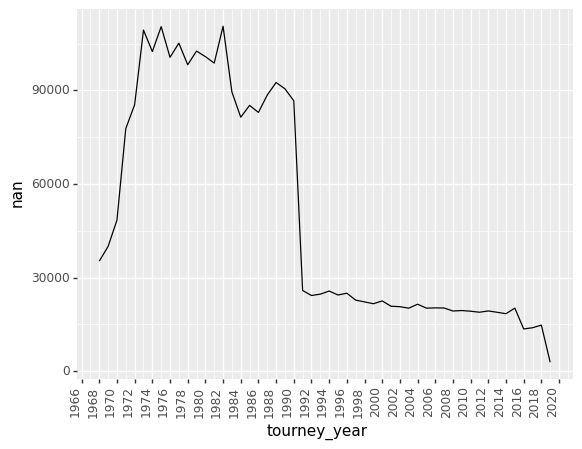

<ggplot: (310404465)>

In [49]:
(
    df >>
    select(X.tourney_year, X.nb_nan) >>
    group_by(X.tourney_year) >>
    summarize(nan = X.nb_nan.sum()) >>
    ggplot(aes(x='tourney_year', y='nan'))
    + geom_line()
    + scale_x_continuous(breaks = range(min(df['tourney_year']) - min(df['tourney_year'])%10,max(df['tourney_year'])+5, 2))
    + theme(axis_text_x=element_text(angle=90, hjust=1))
)

<font color="purple"><b>Les données manquantes concernent principalement les matches d'avant 1993. Pour cette raison, j'ai décidé de restreindre la période de temps du jeu de données utilisé dans la suite. La suite des analyses se fait donc avec les données du 1 er janvier 1993 au début d'année 2019.</b></font>

In [50]:
df = df[df.tourney_year > 1992].reset_index(drop=True)

In [51]:
df.shape

(85370, 51)

<font color="grey-black">Il reste 89100 matches à étudier.</font>

In [52]:
df.isnull().sum()

best_of                   0
draw_size             85370
l_1stIn                8565
l_1stWon               8565
l_2ndWon               8565
l_SvGms                8565
l_ace                  8565
l_bpFaced              8565
l_bpSaved              8565
l_df                   8565
l_svpt                 8565
loser_age               107
loser_entry           68634
loser_hand               43
loser_ht               8353
loser_id                  0
loser_ioc                 0
loser_name                0
loser_rank             1962
loser_rank_points      2497
loser_seed            66584
match_num                 0
minutes                9877
tourney_stage             0
score                     2
surface                 198
tourney_date              0
tourney_id                0
tourney_level             0
tourney_name              0
w_1stIn                8565
w_1stWon               8565
w_2ndWon               8565
w_SvGms                8565
w_ace                  8565
w_bpFaced           

<font color="grey-black">Environ 9000 matches (10% des matches dans le jeu de données) non pas de statistiques sur le déroulé du match (pourcentage de 1er service, de balle de break, du nombre d'aces, etc...). La variable `draw_size` est elle complémtement manquante dans ce nouveau jeu de données.  
Deux options peuvent être envisagé à ce stade, et dans le temps limité: </font>
- <font color="grey-black">Tout simplement les supprimer du jeu de données, mais cela diminuerait encore le nombre de matches disponibles.</font>
- <font color="grey-black">Construire une méthode d'implémentation des données manquantes.</font>

<font color="purple"><b>J'opte pour cette seconde option : pour aller vite, je vais d'abord remplacer les valeurs manquantes par la médiane de la variable.</b></font>

In [53]:
df = df.drop(['draw_size'], axis=1)

In [54]:
df = df.fillna(df.median())

## <font color="green">COORÉLATIONS</font>

<font color="grey-black">Maintenant, pour conclure cette partie d'exploration des données, je vais regarder quelles stastiques des matches sont les plus corrélées entre elles et surtout entre l'issue du match.</font>

In [55]:
df.columns

Index(['best_of', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_ace',
       'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt', 'loser_age', 'loser_entry',
       'loser_hand', 'loser_ht', 'loser_id', 'loser_ioc', 'loser_name',
       'loser_rank', 'loser_rank_points', 'loser_seed', 'match_num', 'minutes',
       'tourney_stage', 'score', 'surface', 'tourney_date', 'tourney_id',
       'tourney_level', 'tourney_name', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df', 'w_svpt',
       'winner_age', 'winner_entry', 'winner_hand', 'winner_ht', 'winner_id',
       'winner_ioc', 'winner_name', 'winner_rank', 'winner_rank_points',
       'winner_seed', 'tourney_year', 'nb_nan'],
      dtype='object')

In [56]:
X = df[["l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_ace", "l_bpFaced", "l_bpSaved", "l_df", "l_svpt", "loser_age", "loser_ht", "loser_rank", "loser_rank_points",
        "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_ace", "w_bpFaced", "w_bpSaved", "w_df", "w_svpt", "winner_age", "winner_ht", "winner_rank", "winner_rank_points",
       ]]
X["result"] = 1

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [57]:
cor = X.corr()

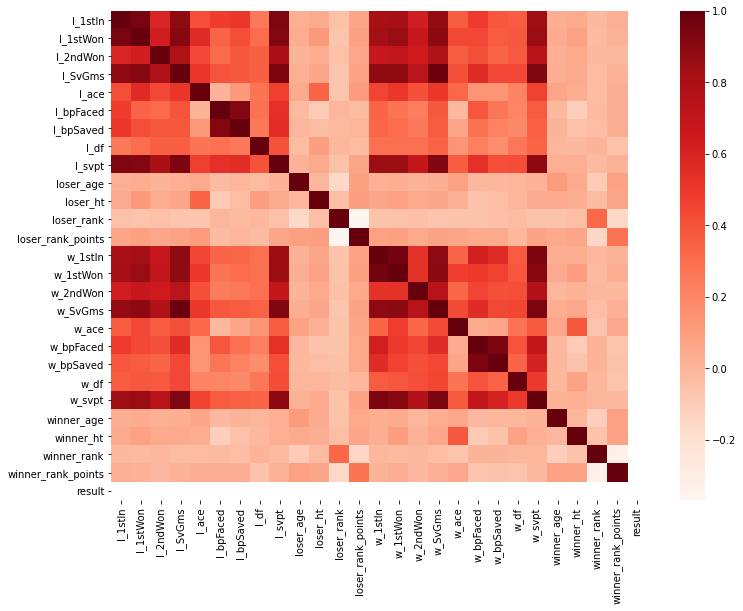

In [58]:
plt.rcParams["figure.figsize"] = (12, 9)
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

<font color="grey-black">Beaucoup de statistiques d'un match sont fortement corrélées entre elles, comme le nombre de 1er services et le nombre de points remportés après un premier service. Mais peu de données sont fortement corrélées avec l'issue d'un match.</font>

## <font color="green">MACHINE LEARNING SETUP</font>

<font color="grey-black">Pour développer mes modèles, je vais construire deux jeux de données : un jeu d'entraînement et un jeu de test. Le jeu d'entraînement sert à construire les modèles de Machine Learning et les ajuster (training), et le second sert à évaluer les performances du modèle construit (testing). Les modèles seront comparés sur leur performance sur le jeu de test.  
15% du jeu de données est reservé pour le jeu de test : 72564 matches serviront à la construction des modèles, et 12806 serviront à mesurer les performances des modèles.</font>

In [59]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=1234)
df_train = df_train.sort_values(['tourney_date', 'tourney_id', 'match_num'])
df_test = df_test.sort_values(['tourney_date', 'tourney_id', 'match_num'])

In [60]:
df_train.shape

(72564, 50)

In [61]:
df_test.shape

(12806, 50)

## <font color="green">PREMIER MODÈLE : BASELINE</font>

<font color="grey-black">Je commence par développer un premier modèle simple, qui sert de baseline pour mesurer les performances d'autres modèles, plus sophistiqués. Toujours commencer par les modèles les plus simples, et si les performances sont bonnes, cela ne sert à rien de développer des modèles plus compliqués, qui seront difficiles à maintenir, à redévelopper dans un autre language si besoin, etc...</font>

<font color="purple"><b>Pour cette baseline, je construis un modèle qui prédit en tant que vainqueur, le joueur le mieux classé au classement ATP.</b></font>

In [62]:
print("Score on train set: {:.1f}%".format((df_train['winner_rank_points'] >= df_train['loser_rank_points']).sum() / df_train.shape[0]*100))

Score on train set: 65.2%


In [63]:
print("Score on test set: {:.1f}%".format((df_test['winner_rank_points'] >= df_test['loser_rank_points']).sum() / df_test.shape[0]*100))

Score on test set: 65.5%


<font color="grey-black">Ce premier modèle a une performance dee 65,5% de bonne prédiction sur le jeu de données test (et 65,2% sur le jeu de donnée d'entraînement).</font>

## <font color="green">DEUXIÈME MODÈLE : MACHINE LEARNING SANS FEATURE ENGINEERING</font>

<font color="grey-black">En deuxième modèle, je décide de partir sur un modèle de classification de Machine Learning. Mais pour ce premier essai, je ne crée pas de nouvelle variable et n'utilise que celle déjà présente dans le jeu de données.</font>

<font color="grey-black"><b>Mais il faut d'abord construire une cible (target) à prévoir. Ici, le joueur qui va gagner le match. On ne peut donc pas se baser sur les données du match en question (nombre de premiers services, d'aces, de balle de break, etc...) car ce sont des données disponibles après la fin du match.</b></font>

<font color="purple"><b>Je décide donc de n'utiliser que les caractéristiques "statiques" des joueurs (taille, classement, points ATP, main préférentielle, etc...) et celle du match (surface, nombre de sets maximum à disputer, ...).</b></font>

<font color="grey-black"><b>Et pour construire ma target, je construis un nouveau jeu de données à partir des données que j'ai : deux joueurs s'affrontent, J1 vs J2. Et la variable à modéliser vaut 1 si le joueur 1 a gagné, et 2 si c'est le joueur 2. Et cette variable est construite de pour avoir environ 50% de J1 vainqueur et 50% de J2 vainqueur. Cette décision d'avoir J1 ou J2 en tant que vainqueur est une décision arbitraire de ma part. Je sépare le jeux de données en 2 (50/50), dans le premier je décide que J1 est le gagnant et dans le second que J2 est vainqueur.</b></font>

<font color="grey-black">Si je ne fais pas cette opération de distinguer J1 ou J2 comme vainqueur, et décide de modéliser J1 en tant que vainqueur de tous les matches, la variable à modéliser ne prends qu'une seule valeur : 1. Elle est donc constante et tous les modèles vont apprendre à prédire 1 tout le temps et auront 100% de bonnes prédictions mais n'auront rien appris.</font>

<font color="grey-black">Cette première fonction renomme l'ensemble des colonnes du jeu de données en fonction de la décision arbitraire d'avoir J1 ou J2 en tant que vainqueur.</font>

In [64]:
def rename_column(data, winner):
    """
    Renommer les colonnes du dataframe pour avoir J1 ou J2 en tant que gagnant
    Et ajouter le nom du gagnant (1 ou 2)
    
    Parameters:
    -----------
    data (pandas DataFrame): donnees de tennis
    winner (Int): J1 ou J2 en tant que gagnant voulu
    
    Return:
    -------
    dataframe (pandas DataFrame): nouveau dataframe avec des colonnes renommees et une colonne cible a modeliser/predire
    """
    
    # test data type
    if type(data) != pd.DataFrame:
        raise ValueError('Parameter data expected to be a pandas DataFrame ; get type(data)={}'.format(type(data)))
    
    # renomme toutes les colonnes
    for col in data.columns:
        # si J1 est voulu comme vainqueur
        if winner == 1:
            data = data.rename({col: col.replace('winner', 'j1')}, axis='columns')
            data = data.rename({col: col.replace('loser', 'j2')}, axis='columns')
        # si J2 est voulu comme vainqueur
        elif winner == 2:
            data = data.rename({col: col.replace('winner', 'j2')}, axis='columns')
            data = data.rename({col: col.replace('loser', 'j1')}, axis='columns')
        # si le gagnat voulu n'est ni J1 ou J2, c'est une erreur
        else:
            raise ValueError('Parameter winner expected to be 1 or 2 ; get winner={}'.format(winner))
    
    return data

<font color="grey-black">Cette seconde fonction traite l'ensemble des variables catégorielles. Si l'on traite le jeu de données test, on s'appuie sur la pipeline de traintement apprise sur le jeu de données d'apprentissage. Il est important d'appliquer la pipeline de données apprises en sur jeu de données d'apprentissage sur le jeu de données test et no d'en construire une nouvelle. C'est une erreur classique qui mène à surestimer les performances du modèles sur jeu de données test.</font><font color="grey-black"><b>Pour aller plus vite et gagner du temps, je traite les colonnes catégorielles avec la fonction [`LabelEncoder` du package scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).</b></font>

<font color="grey-black">Pour traiter les valeurs qui se trouve dans le jeu de données test et pas dans celui d'apprentissage, lors de l'apprentissage je rajoute une catégorie dans chaque variable 'UNKNOWN'. Si une catégorie se trouve uniquement dans le jeu de test, je la traite comme 'UNKNOWN'.</font>

In [65]:
def processing_categorical_data(data, test_set=False,
                                encoder_stage=None, encoder_surface=None, encoder_level=None,
                                encoder_j2_hand=None, encoder_j2_ioc=None, encoder_j2_name=None,
                                encoder_j1_hand=None, encoder_j1_ioc=None, encoder_j1_name=None
                               ):
    """
    Traiter toutes les colonnes catégorielles
    
    Parameters:
    -----------
    data (pandas DataFrame): donnees de tennis avec J1 ou J2 vainqueur
    test_set (Boolean): traitement du jeu de test ou d'apprentissage
    encode_... (sklearn LabelEncoder): LabelEncoder pour traiter la colonne nommee
    
    Return:
    -------
    data (pandas DataFrame): nouveau dataframe avec des colonnes categorielles traitees
    """
    
    # now we need to transform cateforical features
    # and I will use LabelEncoder from sklearn
    # and it is mandatory to treat only categories in the train dataset
    # that's why i will add an 'UNKOWN' value to treat unknow value in the test set
    
    if test_set == False:
        le_tourney_stage = LabelEncoder()
        data['tourney_stage'] = le_tourney_stage.fit_transform(data['tourney_stage'].astype(str).append(pd.Series('UNKNOWN')))[:-1]
        
        le_surface = LabelEncoder()
        data['surface'] = le_surface.fit_transform(data['surface'].astype(str).append(pd.Series('UNKNOWN')))[:-1]

        le_tourney_level = LabelEncoder()
        data['tourney_level'] = le_tourney_level.fit_transform(data['tourney_level'].astype(str).append(pd.Series('UNKNOWN')))[:-1]
        
        le_j2_hand = LabelEncoder()
        data['j2_hand'] = le_j2_hand.fit_transform(data['j2_hand'].astype(str).append(pd.Series('UNKNOWN')))[:-1]
        
        le_j2_ioc = LabelEncoder()
        data['j2_ioc'] = le_j2_ioc.fit_transform(data['j2_ioc'].astype(str).append(pd.Series('UNKNOWN')))[:-1]
        
        le_j2_name = LabelEncoder()
        data['j2_name'] = le_j2_name.fit_transform(data['j2_name'].astype(str).append(pd.Series('UNKNOWN')))[:-1]
        
        le_j1_hand = LabelEncoder()
        data['j1_hand'] = le_j1_hand.fit_transform(data['j1_hand'].astype(str).append(pd.Series('UNKNOWN')))[:-1]
        
        le_j1_ioc = LabelEncoder()
        data['j1_ioc'] = le_j1_ioc.fit_transform(data['j1_ioc'].astype(str).append(pd.Series('UNKNOWN')))[:-1]
        
        le_j1_name = LabelEncoder()
        data['j1_name'] = le_j1_name.fit_transform(data['j1_name'].astype(str).append(pd.Series('UNKNOWN')))[:-1]
        
        return data, le_tourney_stage, le_surface, le_tourney_level, le_j2_hand, le_j2_ioc, le_j2_name, le_j1_hand, le_j1_ioc, le_j1_name
    else:
        data.loc[~data['tourney_stage'].isin(encoder_stage.classes_), 'tourney_stage'] = 'UNKNOWN'
        data['tourney_stage'] = encoder_stage.transform(data['tourney_stage'].astype(str))
        
        data.loc[~data['surface'].isin(encoder_surface.classes_), 'surface'] = 'UNKNOWN'
        data['surface'] = encoder_surface.transform(data['surface'].astype(str))
        
        data.loc[~data['tourney_level'].isin(encoder_level.classes_), 'tourney_level'] = 'UNKNOWN'
        data['tourney_level'] = encoder_level.transform(data['tourney_level'].astype(str))
        
        data.loc[~data['j2_hand'].isin(encoder_j2_hand.classes_), 'j2_hand'] = 'UNKNOWN'
        data['j2_hand'] = encoder_j2_hand.transform(data['j2_hand'].astype(str))

        data.loc[~data['j2_ioc'].isin(encoder_j2_ioc.classes_), 'j2_ioc'] = 'UNKNOWN'
        data['j2_ioc'] = encoder_j2_ioc.transform(data['j2_ioc'].astype(str))
        
        data.loc[~data['j2_name'].isin(encoder_j2_name.classes_), 'j2_name'] = 'UNKNOWN'
        data['j2_name'] = encoder_j2_name.transform(data['j2_name'].astype(str))
        
        data.loc[~data['j1_hand'].isin(encoder_j1_hand.classes_), 'j1_hand'] = 'UNKNOWN'
        data['j1_hand'] = encoder_j1_hand.transform(data['j1_hand'].astype(str))
        
        data.loc[~data['j1_ioc'].isin(encoder_j1_ioc.classes_), 'j1_ioc'] = 'UNKNOWN'
        data['j1_ioc'] = encoder_j1_ioc.transform(data['j1_ioc'].astype(str))
        
        data.loc[~data['j1_name'].isin(encoder_j1_name.classes_), 'j1_name'] = 'UNKNOWN'
        data['j1_name'] = encoder_j1_name.transform(data['j1_name'].astype(str))
        
        return data      

<font color="grey-black">Cette troisième fonction, traite le jeu de donnée en créant les colonnes de statistiques pour J1 et J2 et la variable à modéliser.</font>

In [66]:
def processing(data):
    """
    Premier processing du jeu de donnees
    
    Parameters:
    -----------
    data (pandas DataFrame): donnees de tennis
    
    Return:
    -------
    dataframe (pandas DataFrame): nouveau dataframe avec traitee et sans la variable a modeliser
    y (pandas Serie): variable a modeliser et predire
    """
    # select statics columns
    dataframe = data[[
        'best_of', 'match_num', 'tourney_stage', 'surface', 'tourney_date',
        'tourney_id', 'tourney_level', 'tourney_name', 'tourney_year',
        'loser_age', 'loser_hand', 'loser_ht', 'loser_id',
        'loser_ioc', 'loser_name', 'loser_rank', 'loser_rank_points', 'loser_seed',
        'winner_age', 'winner_hand', 'winner_ht', 'winner_id',
        'winner_ioc', 'winner_name', 'winner_rank', 'winner_rank_points', 'winner_seed',
    ]]
    
    # split the data: train1 will have J1 as winner and train2 will have J2 as winner
    df1, df2 = train_test_split(dataframe, test_size=0.5, random_state=1234)
    
    df1 = rename_column(data=df1, winner=1)
    df2 = rename_column(data=df2, winner=2)
    
    dataframe = pd.concat([df1, df2])
    
    dataframe['winner'] = np.concatenate((np.ones(shape=df1.shape[0]), np.ones(shape=df2.shape[0])*2))
    
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    
    y = dataframe['winner']
    dataframe = dataframe.drop(['winner'], axis='columns')
    
    # to train our model, it is necessary to drop some columns because they should not influence doivent pas avoir d'influence
    # our prediction like player's ID (because it is arbitrary)
    dataframe = dataframe.drop([
        'match_num', 'tourney_date', 'tourney_id', 'tourney_name', 'tourney_year',
        'j2_id', 'j1_id'],
        axis='columns')
    
    return dataframe, y

In [67]:
X_train, y_train = processing(df_train)
X_test, y_test = processing(df_test)

In [68]:
X_train.head()

,best_of,tourney_stage,surface,tourney_level,j2_age,j2_hand,j2_ht,j2_ioc,j2_name,j2_rank,j2_rank_points,j2_seed,j1_age,j1_hand,j1_ht,j1_ioc,j1_name,j1_rank,j1_rank_points,j1_seed
0,3,R16,Carpet,A,21.85,R,180.0,SWE,Thomas Johansson,64.0,741.0,6.0,25.37,L,193.0,CRO,Goran Ivanisevic,2.0,3566.0,1.0
1,3,R32,Clay,A,27.40,R,180.0,ITA,Laurence Tieleman,110.0,370.0,5.0,28.54,R,185.0,BUL,Orlin Stanoytchev,97.0,413.0,6.0
2,3,R32,Hard,A,21.26,R,185.0,THA,Paradorn Srichaphan,93.0,459.0,6.0,24.30,R,188.0,SWE,Magnus Norman,4.0,3196.0,3.0
3,3,QF,Hard,A,28.93,R,180.0,USA,Andre Agassi,12.0,2071.0,3.0,21.75,R,183.0,GER,Nicolas Kiefer,26.0,1198.0,5.0
4,5,R32,Hard,G,25.03,R,170.0,ARG,Diego Sebastian Schwartzman,33.0,1280.0,29.0,28.91,R,198.0,CRO,Marin Cilic,7.0,4155.0,5.0


In [69]:
(X_train, encoder_stage, encoder_surface, encoder_level,
 encoder_j2_hand, encoder_j2_ioc, encoder_j2_name,
 encoder_j1_hand, encoder_j1_ioc, encoder_j1_name) = processing_categorical_data(X_train)

In [70]:
X_test = processing_categorical_data(X_test, test_set=True,
                                     encoder_stage=encoder_stage, encoder_surface=encoder_surface, encoder_level=encoder_level,
                                     encoder_j2_hand=encoder_j2_hand, encoder_j2_ioc=encoder_j2_ioc, encoder_j2_name=encoder_j2_name,
                                     encoder_j1_hand=encoder_j1_hand, encoder_j1_ioc=encoder_j1_ioc, encoder_j1_name=encoder_j1_name)

<font color="grey-black">Maintenant les deux jeux de données (apprentissage et test) sont prêts pour commencer l'apprentissage d'un modèle de Machine Learning. Toujours dans l'optique de gagner du temps, j'utilise le package [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn) qui permet de rapidement tester un ensemble de modèles disponibles dans [la package scikit-learn](https://scikit-learn.org/stable/index.html) et de trouver le meilleur modèle avec le meilleur jeu de paramètres qui performent le mieux sur le jeu de données d'apprentissage. Ce package utilise des algorithmes d'optimisation d'hyper paramètres avec des statistiques bayésiennes. Cela permet de gagner un temps substensiel dans la recherche du modèle et est bien plus performant et sophistiqué qu'un [GridSearch](https://scikit-learn.org/stable/modules/grid_search.html) largement utilisé dans la communauté Data Science.</font>

In [71]:
estim = HyperoptEstimator(classifier=any_classifier('my_clf'),
                          preprocessing=any_preprocessing('my_pre'),
                          algo=tpe.suggest,
                          max_evals=100,
                          trial_timeout=60)

<div class="alert alert-danger">
  <strong>Attention !</strong> Le temps d'évaluation et d'optimisation de l'ensemble des modèles est extrêmement long (peu aller jusqu'à plus d'une heure et demie). Je ne conseille pas de rejouer la cellule suivante mais de directement regarder les résultats, et le meilleur modèle obtenu.
</div>

In [96]:
estim.fit(X_train, y_train)

 93%|█████████▎| 14/15 [00:00<?, ?trial/s, best loss=?]

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



 96%|█████████▌| 24/25 [00:00<?, ?trial/s, best loss=?]

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



 96%|█████████▌| 25/26 [00:00<?, ?trial/s, best loss=?]

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



 96%|█████████▋| 26/27 [00:00<?, ?trial/s, best loss=?]

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



 96%|█████████▋| 27/28 [00:00<?, ?trial/s, best loss=?]

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



 97%|█████████▋| 29/30 [00:00<?, ?trial/s, best loss=?]

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



 97%|█████████▋| 30/31 [00:00<?, ?trial/s, best loss=?]

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



 97%|█████████▋| 34/35 [00:00<?, ?trial/s, best loss=?]

/Users/antoinemertz/.local/share/virtualenvs/tennis-game-prediction-G_Zh9rmk/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



100%|██████████| 100/100 [01:00<00:00,  1.66trial/s, best loss: 0.030110935023771823]


In [106]:
estim.best_model()

{'learner': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None,
                        max_features=0.25152305197906943, max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=40,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=911, n_jobs=1, oob_score=False,
                        random_state=1, verbose=False, warm_start=False),
 'preprocs': (MinMaxScaler(copy=True, feature_range=(0.0, 1.0)),),
 'ex_preprocs': ()}

<font color="grey-black">Le meilleur modèle trouver un le modèle [RandoForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier). On pouvait s'y attendre car c'est un modèle très utilisé et bien connu et qui a généralement des bonnes performances sur des problèmes de Machine Learning usuels comme la prédiction que l'on traite. C'est un modèle qui permet de bien traiter les variables issues du traitement des variables catégorielles et les variables numériques. C'est exactement notre cas ici.</font>

In [72]:
X_train.head()

,best_of,tourney_stage,surface,tourney_level,j2_age,j2_hand,j2_ht,j2_ioc,j2_name,j2_rank,j2_rank_points,j2_seed,j1_age,j1_hand,j1_ht,j1_ioc,j1_name,j1_rank,j1_rank_points,j1_seed
0,3,4,0,0,21.85,1,180.0,99,2205,64.0,741.0,6.0,25.37,0,193.0,24,792,2.0,3566.0,1.0
1,3,5,1,0,27.40,1,180.0,50,1298,110.0,370.0,5.0,28.54,1,185.0,16,1741,97.0,413.0,6.0
2,3,5,3,0,21.26,1,185.0,101,1758,93.0,459.0,6.0,24.30,1,188.0,102,1374,4.0,3196.0,3.0
3,3,2,3,0,28.93,1,180.0,112,148,12.0,2071.0,3.0,21.75,1,183.0,40,1683,26.0,1198.0,5.0
4,5,5,3,3,25.03,1,170.0,3,551,33.0,1280.0,29.0,28.91,1,198.0,24,1435,7.0,4155.0,5.0


In [74]:
scaler = MinMaxScaler(copy=True, feature_range=(0.0, 1.0))
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0.0, 1.0))

In [75]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                             criterion='gini', max_depth=None,
                             max_features=0.25152305197906943, max_leaf_nodes=None,
                             max_samples=None, min_impurity_decrease=0.0,
                             min_impurity_split=None, min_samples_leaf=40,
                             min_samples_split=2, min_weight_fraction_leaf=0.0,
                             n_estimators=911, n_jobs=1, oob_score=False,
                             random_state=1, verbose=False, warm_start=False)

In [77]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None,
                       max_features=0.25152305197906943, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=40,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=911, n_jobs=1, oob_score=False,
                       random_state=1, verbose=False, warm_start=False)

In [78]:
print("Sur l'ensemble d'apprentissage, le modèle a {:.2f}% de bonnes prédiction".format(clf.score(X_train, y_train)*100))

Sur l'ensemble d'apprentissage, le modèle a 97.10% de bonnes prédiction


In [79]:
print("Sur l'ensemble de test, le modèle a {:.2f}% de bonnes prédiction".format(clf.score(X_test, y_test)*100))

Sur l'ensemble de test, le modèle a 96.91% de bonnes prédiction


<font color="grey-black">Le modèle a donc une performance de presque 97% de bonnes prédictions sur les deux jeux de données (apprentissage et test). Le modèle a donc très bien appris. (Sauf si j'ai un souci de data leakage que je n'ai pas su voir dans le temps limité de l'exercice).</font>

# <font color="orange">CONCLUSION</font>

<font color="grey-black">Dans ce notebook j'ai essayé de faire passer au lecteur mes compétences en programmation et en Machine Learning. Mais j'ai surtout voulu montrer ma démarche lors d'un exercice de Data Science :</font>

<font color="grey-black">D'abord être sur de bien comprendre le jeu de données en construisant le dictionnaire de données. Puis commencer par nettoyer le jeu de données en regardant les valeurs manquantes, le type des données, les valeurs aberrantes, et les hypothèses pour traiter ces données.</font>

<font color="grey-black">Ensuite avec la data visualisation et les tests statistiques je me donne une idée sur les données que je manipule. Quelle est la ditribution des données ? Existe-t-il des points qui peuvent être des freins à la modélisation ? Etc... Mais toujours en gardant en tête le but e l'exercice : quelle variable veut-on prédire ? C'est l'objectif de ma partie EDA.</font>

<font color="grey-black">Une fois les données assimilées (ou à peu près comprises si le temps est limité) je me lance dans la partie modélisation : garder une partie du jeu de données pour tester la performance des modèles et les comparer, commencer par un modèle "benchmark" simple, essayer d'utiliser des outils qui accelèrent le développement et la recherche de modèles, etc...</font>

<font color="grey-black">Biensur, en 8 heures, il n'est pas possible de développer toutes ces parties mentionnées et importantes dans leur intégralité mais je laisse au lecteur le soin de regarder la partie suivante qui liste quelques idées de développements possibles pour la suite.</font>

# <font color="orange">POUR ALLER PLUS LOIN...</font>

<font color="grey-black">Ce travail a été fait en un temps limité (8 heures). Mais beaucoup de travail reste à faire avant de trouver le meilleur modèle possible de prédiction de l'issue d'un match de tennis. Je liste ici l'ensemble des tâches incomplètes ou non faites par manque de temps mais qui sont importantes dans une démarche d'analyse de données et de construction d'un modèle de prédiction.</font>

- [ ] <font color="grey-black">Regarder l'ensemble des distributions des variables quantitatives et qualitatives</font>
- [ ] <font color="grey-black">Analyser les influences et les corrélations de l'ensemble des variables quantitatives et qualitatives sur l'issue d'un match</font>
- [ ] <font color="grey-black">Essayer de transformer les variables pour se rapprocher d'une distribution normale pour les varioables quantitatives et d'une distribution équilibrée pour les variables qualitatives (pour se rapprocher des distributions théoriques idéales pour l'utilisation de modèle de machine learning et avoir de meilleures performances des modèles)</font>
- [ ] <font color="grey-black">Construire une meilleure implémentation des valeurs manquantes (knn, kmeans, ...)</font>
- [ ] <font color="grey-black">Analyser l'influence sur les distributions et sur les résultats des modèles des différentes stratégie des implémentations des valeurs manquantes</font>
- [ ] <font color="grey-black">Mieux traiter les colonnes catégorielles et tester plusieurs méthodes (one hot encoding, Cat2Vec, ...)</font>
- [ ] <font color="grey-black">Prendre en compte les données historiques des joueurs : forme du moment, ratio historique de victoire, performance sur la surface du match , etc...</font>
- [ ] <font color="grey-black">Regarder l'historique des face à face entre les deux joueurs</font>